<a href="https://colab.research.google.com/github/Shivakumarsullagaddi/CCBD_MRI/blob/main/2D_RESNET34_metadata_BC_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Binary Classification
#2D slices + ResNet34 + Metadata Fusion

0 → CN (Not Alzheimer's)

1 → AD (Alzheimer's)



---
Improved from 3nd code

---



*   Applying Data Argumentation
*   XML File Handling for meta data
*   Better visualization
*   Improved ROC curve



```
 FOR ACC need to hit and trial Tunning, need to find it
 for now Loss=0.1189 Train Acc=96.77% Val Acc=59.38%
```

**Problem :** *Model unable to distinguish between the axial,sagatial,coronal*
            

> model is overfitting: it performs well on training data but poorly on validation data        <br>->need focus on regularization, augmentation, and careful evaluation using multiple metrics

> Overfitting (high training accuracy, low loss), but it is not generalizing to unseen (validation) data

> Model Generalization is Poor

>Plane information is missing ("Unknown") is not corretly clarified

**Which models need to use to Overcome**

**models for**

>CCNs : (both for classification and segemtation) : 3D ResNet ,MedicalNet

>Latest segmentation()  : SegCaps, UNet


**learning**
<br>We Need clarity

get tha dataset

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
import zipfile

zip_path = '/content/drive/MyDrive/MRI_DATASET/nifti_with_metadata.zip'
extract_path = '/content/drive/MyDrive/MRI_DATASET/nifti_with_metadata'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


import

In [24]:
# --- Imports and Setup ---
import os
import random
import torch
import numpy as np
import nibabel as nib
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


parshing meatadata

In [32]:
def parse_xml_metadata(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    meta = {}

    # Demographics
    sex_node = root.find('.//subjectSex')
    meta['sex'] = 1 if (sex_node is not None and sex_node.text == 'M') else 0

    age_node = root.find('.//subjectAge')
    meta['age'] = float(age_node.text) if age_node is not None else 0.0

    # Genetics
    apoe1_node = root.find('.//subjectInfo[@item="APOE A1"]')
    meta['apoe1'] = int(apoe1_node.text) if apoe1_node is not None else 0

    apoe2_node = root.find('.//subjectInfo[@item="APOE A2"]')
    meta['apoe2'] = int(apoe2_node.text) if apoe2_node is not None else 0

    # Clinical Scores
    def safe_find(path, default=0.0):
        node = root.find(path)
        try:
            return float(node.text)
        except:
            return default

    meta['mmse'] = safe_find('.//assessmentScore[@attribute="MMSCORE"]')
    meta['cdr']  = safe_find('.//assessmentScore[@attribute="CDGLOBAL"]')
    meta['faq']  = safe_find('.//assessmentScore[@attribute="FAQTOTAL"]')
    meta['gds']  = safe_find('.//assessmentScore[@attribute="GDTOTAL"]')

    # Imaging Protocol
    protocol = root.find('.//imagingProtocol/protocolTerm')
    def get_protocol(term, default=0.0):
        if protocol is not None:
            node = protocol.find(f'.//protocol[@term="{term}"]')
            try:
                return float(node.text)
            except:
                return default
        else:
            return default

    meta['field_strength']   = get_protocol('Field Strength')
    meta['slice_thickness']  = get_protocol('Slice Thickness')
    meta['tr']               = get_protocol('TR')
    meta['te']               = get_protocol('TE')
    meta['flip_angle']       = get_protocol('Flip Angle')

    return meta


Data argumentation

In [33]:
# --- Data Augmentation and Transforms ---
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


custom dataset with metadata

In [34]:
# --- Custom Dataset with Metadata ---
class MRIDatasetWithMeta(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples  # [(nii_path, xml_path, label)]
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        nii_path, xml_path, label = self.samples[idx]
        # Central 2D slice extraction
        img = nib.load(nii_path).get_fdata()
        slice_idx = img.shape[2] // 2
        slice_img = img[:, :, slice_idx]
        slice_img = (slice_img - np.min(slice_img)) / (np.max(slice_img) - np.min(slice_img) + 1e-8)
        slice_img = (slice_img * 255).astype(np.uint8)
        pil_img = Image.fromarray(slice_img).convert('RGB')
        if self.transform:
            pil_img = self.transform(pil_img)
        # Metadata vector
        meta = parse_xml_metadata(xml_path)
        meta_vec = torch.tensor([
            meta['sex'], meta['age'], meta['apoe1'], meta['apoe2'],
            meta['mmse'], meta['cdr'], meta['faq'], meta['gds'],
            meta['field_strength'], meta['slice_thickness'],
            meta['tr'], meta['te'], meta['flip_angle']
        ], dtype=torch.float32)
        return pil_img, meta_vec, label


prepare dataset

In [35]:
# --- Prepare Data Splits (AD vs. CN only) ---
import os
import random

root_dir = '/content/drive/MyDrive/MRI_DATASET/nifti_with_metadata/nifti_with_metadata'
class_names = ['AD', 'CN']
class_map = {'CN': 0, 'AD': 1}
random.seed(42)

train_samples, val_samples, test_samples = [], [], []

for cls in class_names:
    class_dir = os.path.join(root_dir, cls)
    subjects = sorted(os.listdir(class_dir))
    random.shuffle(subjects)
    n_total = len(subjects)
    n_train = int(0.7 * n_total)
    n_val = int(0.15 * n_total)
    n_test = n_total - n_train - n_val

    train_subjs = subjects[:n_train]
    val_subjs = subjects[n_train:n_train + n_val]
    test_subjs = subjects[n_train + n_val:]

    for subj_list, sample_list in zip([train_subjs, val_subjs, test_subjs],
                                      [train_samples, val_samples, test_samples]):
        for subj in subj_list:
            subj_dir = os.path.join(class_dir, subj)

            # Find the XML file (any filename with .xml extension)
            xml_files = [f for f in os.listdir(subj_dir) if f.endswith('.xml')]
            if not xml_files:
                raise FileNotFoundError(f"No XML file found in {subj_dir}")
            xml_path = os.path.join(subj_dir, xml_files[0])  # Use first found XML

            # Find the NIfTI file (any filename with .nii or .nii.gz)
            nii_files = [f for f in os.listdir(subj_dir)
                         if f.endswith('.nii') or f.endswith('.nii.gz')]
            if not nii_files:
                raise FileNotFoundError(f"No NIfTI file found in {subj_dir}")

            for nii_file in nii_files:
                nii_path = os.path.join(subj_dir, nii_file)
                sample_list.append((nii_path, xml_path, class_map[cls]))


Create Datasets and DataLoaders (with Hyperparameters)

In [36]:
# --- DataLoaders ---
batch_size = 32
train_dataset = MRIDatasetWithMeta(train_samples, transform=train_transform)
val_dataset = MRIDatasetWithMeta(val_samples, transform=val_test_transform)
test_dataset = MRIDatasetWithMeta(test_samples, transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


load and modify resnet

In [37]:
# --- Model: ResNet34 + Metadata Fusion ---
class ResNetWithMeta(nn.Module):
    def __init__(self, num_meta=13, num_classes=2):
        super().__init__()
        self.resnet = models.resnet34(pretrained=True)
        self.resnet.fc = nn.Identity()
        self.meta_fc = nn.Sequential(
            nn.Linear(num_meta, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 + 32, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x_img, x_meta):
        img_feat = self.resnet(x_img)
        meta_feat = self.meta_fc(x_meta)
        x = torch.cat([img_feat, meta_feat], dim=1)
        return self.classifier(x)

model = ResNetWithMeta().to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Training and Hyperparameter Tuning

In [38]:
# --- Training Loop with Regularization ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

for epoch in range(15):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for imgs, metas, labels in train_loader:
        imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs, metas)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_acc = 100 * correct / total

    # Validation
    model.eval()
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, metas, labels in val_loader:
            imgs, metas, labels = imgs.to(device), metas.to(device), labels.to(device)
            outputs = model(imgs, metas)
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()
    val_acc = 100 * val_correct / val_total

    print(f"Epoch {epoch+1}: Loss={running_loss/len(train_loader.dataset):.4f} "
          f"Train Acc={train_acc:.2f}% Val Acc={val_acc:.2f}%")


Epoch 1: Loss=0.7094 Train Acc=55.48% Val Acc=50.00%
Epoch 2: Loss=0.6231 Train Acc=65.16% Val Acc=50.00%
Epoch 3: Loss=0.5773 Train Acc=69.03% Val Acc=43.75%
Epoch 4: Loss=0.5262 Train Acc=74.84% Val Acc=46.88%
Epoch 5: Loss=0.4321 Train Acc=83.23% Val Acc=53.12%
Epoch 6: Loss=0.3937 Train Acc=83.23% Val Acc=62.50%
Epoch 7: Loss=0.3006 Train Acc=90.97% Val Acc=56.25%
Epoch 8: Loss=0.2732 Train Acc=88.39% Val Acc=65.62%
Epoch 9: Loss=0.2874 Train Acc=89.03% Val Acc=68.75%
Epoch 10: Loss=0.1880 Train Acc=94.19% Val Acc=56.25%
Epoch 11: Loss=0.2207 Train Acc=90.97% Val Acc=53.12%
Epoch 12: Loss=0.2165 Train Acc=90.97% Val Acc=59.38%
Epoch 13: Loss=0.1480 Train Acc=96.13% Val Acc=65.62%
Epoch 14: Loss=0.1453 Train Acc=92.90% Val Acc=53.12%
Epoch 15: Loss=0.1189 Train Acc=96.77% Val Acc=59.38%


Validation and Advanced Metrics

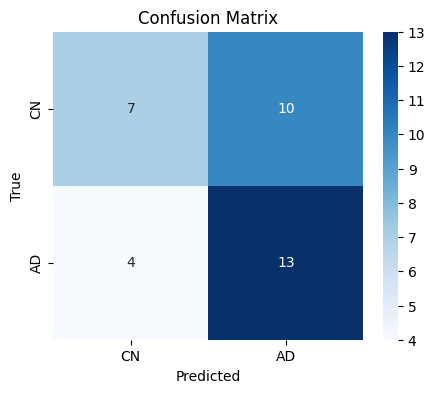

              precision    recall  f1-score   support

          CN       0.64      0.41      0.50        17
          AD       0.57      0.76      0.65        17

    accuracy                           0.59        34
   macro avg       0.60      0.59      0.57        34
weighted avg       0.60      0.59      0.58        34



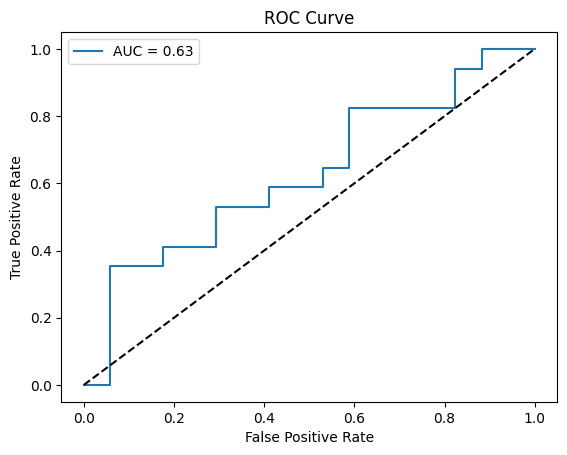

ROC AUC: 0.626


In [40]:
model.eval()
all_preds, all_targets, all_probs = [], [], []

with torch.no_grad():
    for images, metas, labels in test_loader:
        images, metas = images.to(device), metas.to(device)
        outputs = model(images, metas)
        probs = torch.softmax(outputs, dim=1)[:,1]
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.numpy())
        all_probs.extend(probs.cpu().numpy())


# Confusion Matrix
cm = confusion_matrix(all_targets, all_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["CN", "AD"],
            yticklabels=["CN", "AD"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(all_targets, all_preds, target_names=["CN", "AD"]))

# ROC/AUC
auc = roc_auc_score(all_targets, all_probs)
fpr, tpr, _ = roc_curve(all_targets, all_probs)
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
print(f"ROC AUC: {auc:.3f}")


#For visualization

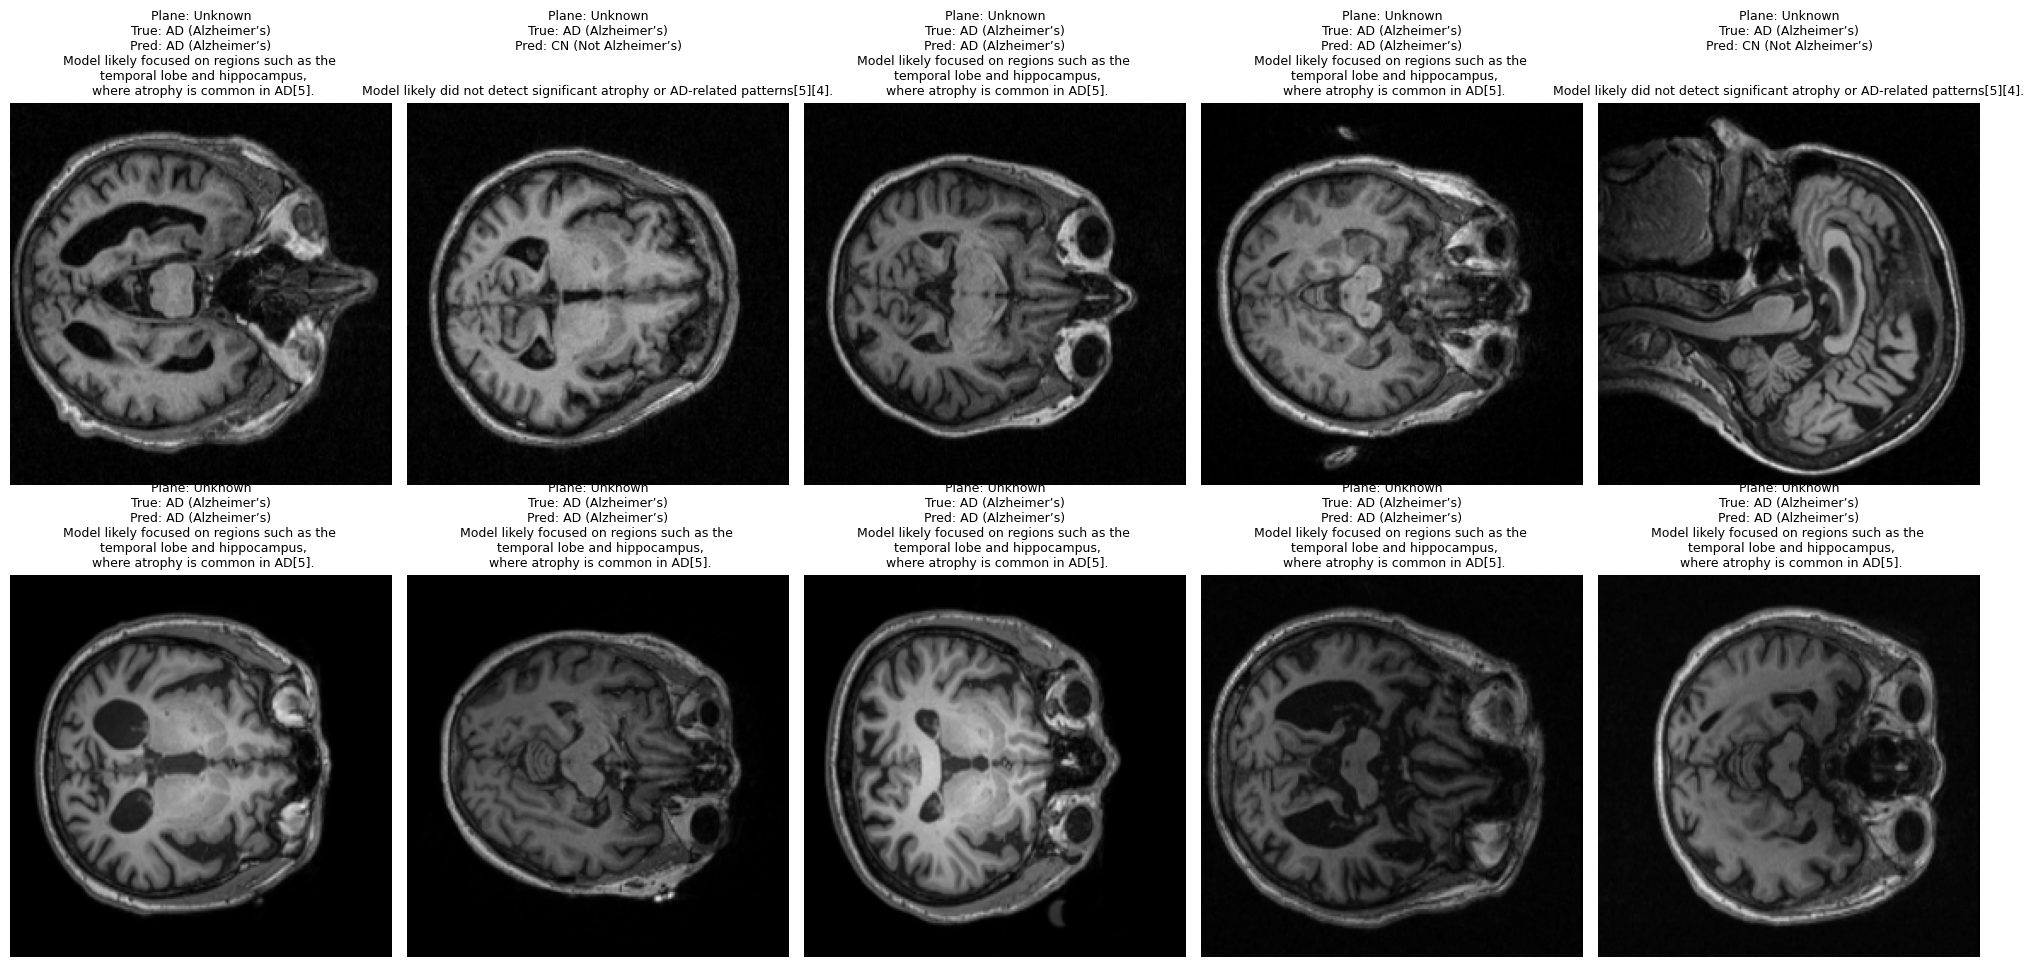

In [46]:
num_examples = 10
plt.figure(figsize=(20, 10))
class_names = {0: "CN (Not Alzheimer’s)", 1: "AD (Alzheimer’s)"}

for idx in range(num_examples):
    # Get image, metadata, and label from the dataset
    img_tensor, meta_vec, label = test_dataset[idx]
    img = img_tensor.numpy().transpose(1,2,0)
    img = (img * 0.5 + 0.5) * 255
    img = img.astype('uint8')
    true_label = label
    pred_label = all_preds[idx]

    # Get acquisition plane from metadata (assuming you have xml_path in your sample list)
    nii_path, xml_path, _ = test_samples[idx]
    meta = parse_xml_metadata(xml_path)
    plane = meta.get('acq_plane', 'Unknown').capitalize()

    # Simple explanation for visualization
    if pred_label == 1:
        explanation = "Model likely focused on regions such as the \n temporal lobe and hippocampus,\n where atrophy is common in AD[5]."
    else:
        explanation = "\n\nModel likely did not detect significant atrophy or AD-related patterns[5][4]."

    plt.subplot(2, 5, idx+1)
    plt.imshow(img)
    plt.title(
        f"Plane: {plane}\n"
        f"True: {class_names[true_label]}\n"
        f"Pred: {class_names[pred_label]}\n"
        f"{explanation}",
        fontsize=9
    )
    plt.axis('off')

plt.tight_layout()
plt.show()
